In [1]:
from pathlib import Path

import pyarrow.dataset as ds
import pyarrow as pa
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression

from lib.phenotype.constants import DEFAULT_METADATA_COLS
from lib.aggregate.align import prepare_alignment_data, centerscale_on_controls
from lib.aggregate.cell_data_utils import load_metadata_cols, split_cell_data

/home/rkern/miniconda3/envs/brieflow_denali_analysis_new/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-08-19 17:25:08.605855: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755638708.961707 2813638 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755638709.064427 2813638 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755638709.849289 2813638 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the

In [9]:
filtered_data_dir = Path(
    "/lab/ops_analysis/cheeseman/denali-analysis/analysis/brieflow_output/aggregate/parquets"
)
filtered_data_paths = list(
    filtered_data_dir.glob("*_CeCl-Interphase_ChCo-DAPI_CENPA__filtered.parquet")
)

filtered_data_paths

[PosixPath('/lab/ops_analysis/cheeseman/denali-analysis/analysis/brieflow_output/aggregate/parquets/P-1_W-A1_CeCl-Interphase_ChCo-DAPI_CENPA__filtered.parquet'),
 PosixPath('/lab/ops_analysis/cheeseman/denali-analysis/analysis/brieflow_output/aggregate/parquets/P-3_W-B3_CeCl-Interphase_ChCo-DAPI_CENPA__filtered.parquet'),
 PosixPath('/lab/ops_analysis/cheeseman/denali-analysis/analysis/brieflow_output/aggregate/parquets/P-1_W-B3_CeCl-Interphase_ChCo-DAPI_CENPA__filtered.parquet'),
 PosixPath('/lab/ops_analysis/cheeseman/denali-analysis/analysis/brieflow_output/aggregate/parquets/P-1_W-A3_CeCl-Interphase_ChCo-DAPI_CENPA__filtered.parquet'),
 PosixPath('/lab/ops_analysis/cheeseman/denali-analysis/analysis/brieflow_output/aggregate/parquets/P-2_W-A1_CeCl-Interphase_ChCo-DAPI_CENPA__filtered.parquet'),
 PosixPath('/lab/ops_analysis/cheeseman/denali-analysis/analysis/brieflow_output/aggregate/parquets/P-2_W-A2_CeCl-Interphase_ChCo-DAPI_CENPA__filtered.parquet'),
 PosixPath('/lab/ops_analysi

In [ ]:
GENE = "RPS8"  # high perturbation score example
# GENE = "PTP4A2"  # low perturbation score example

subset_dfs = []
for filtered_data_path in filtered_data_paths:
    print(f"Loading {filtered_data_path}")
    filtered_dataset = ds.dataset(filtered_data_path, format="parquet")
    perturbation_col = filtered_dataset.to_table(columns=["gene_symbol_0"]).to_pandas()[
        "gene_symbol_0"
    ]

    gene_indices = perturbation_col.str.contains(GENE, na=False).to_numpy().nonzero()[0]
    nontargeting_indices = (
        perturbation_col.str.contains("nontargeting", na=False).to_numpy().nonzero()[0]
    )
    nontargeting_indices = np.random.choice(
        nontargeting_indices, size=len(gene_indices), replace=False
    )
    combined_indices = np.union1d(gene_indices, nontargeting_indices)

    subset_df = filtered_dataset.scanner().take(pa.array(combined_indices))
    subset_df = subset_df.to_pandas(use_threads=True, memory_pool=None).reset_index(
        drop=True
    )

    subset_dfs.append(subset_df)

subset_df = pd.concat(subset_dfs, ignore_index=True)
subset_df

Loading /lab/ops_analysis/cheeseman/denali-analysis/analysis/brieflow_output/aggregate/parquets/P-1_W-A1_CeCl-Interphase_ChCo-DAPI_CENPA__filtered.parquet


In [ ]:
metadata_cols = DEFAULT_METADATA_COLS + ["class", "confidence"]
feature_cols = subset_df.columns.difference(metadata_cols, sort=False)

metadata, features = split_cell_data(subset_df, metadata_cols)
metadata, features = prepare_alignment_data(
    metadata,
    features,
    ["plate", "well"],
    "gene_symbol_0",
    "nontargeting",
    "sgRNA_0",
)
features = features.astype(np.float32)

features = centerscale_on_controls(
    features,
    metadata,
    "gene_symbol_0",
    "nontargeting",
    "batch_values",
)
features = pd.DataFrame(features, columns=feature_cols)

subset_df_scaled = pd.concat([metadata, features], axis=1)

/lab/ops_analysis/cheeseman/denali-analysis/brieflow/workflow/lib/aggregate/align.py:244: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  batch_ind & (metadata[pert_col].str.startswith(control_key)).to_list()
/lab/ops_analysis/cheeseman/denali-analysis/brieflow/workflow/lib/aggregate/align.py:244: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  batch_ind & (metadata[pert_col].str.startswith(control_key)).to_list()
/lab/ops_analysis/cheeseman/denali-analysis/brieflow/workflow/lib/aggregate/align.py:244: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are dep

In [ ]:
def get_top_differential_features(cell_data, feature_cols, gene, n_features=100):
    """Get top differentially expressed features between control and gene using t-test"""
    results = []

    control_cells = cell_data[cell_data["gene_symbol_0"].str.startswith("nontargeting")]
    gene_cells = cell_data[cell_data["gene_symbol_0"] == gene]

    for feature in feature_cols:
        if feature not in control_cells.columns or feature not in gene_cells.columns:
            continue

        control_values = control_cells[feature].dropna()
        gene_values = gene_cells[feature].dropna()

        if len(control_values) < 2 or len(gene_values) < 2:
            continue

        t_stat, p_value = stats.ttest_ind(control_values, gene_values, equal_var=False)

        results.append(
            {
                "feature": feature,
                "pvalue": p_value,
                "control_mean": control_values.mean(),
                "gene_mean": gene_values.mean(),
            }
        )

    results_df = pd.DataFrame(results).sort_values("pvalue")
    return results_df.head(n_features)["feature"].tolist()


diff_exp_features = get_top_differential_features(
    subset_df_scaled,
    feature_cols,
    GENE,
    n_features=200,
)

## Derive Perturbation Score

We aim to implement a modified version of the perturbation score methodology from [Li et al., 2025](https://www.nature.com/articles/s41556-025-01626-9) on our phenotypic features.
Our implementation is:
1) Identify top n differential features with a two‑sample t‑test (perturbation vs. nontargeting controls).
2) Compute the perturbation signature β = mean(feature values in gene‑perturbed cells) − mean(feature values in controls) for those features.
3) Project and scale:
    - Project every cell onto β to obtain a scalar score.
    - Fit a 1‑D linear model to map this projection onto the binary gene label, then rescale the prediction to the [0, 1] interval to yield the final perturbation score.

In [ ]:
def get_perturbation_score(cell_data, gene, diff_exp_features):
    """Compute perturbation scores for a given gene using a projection-based method."""

    feature_data = cell_data[diff_exp_features]
    gene_mask = cell_data["gene_symbol_0"] == gene
    control_mask = cell_data["gene_symbol_0"].str.startswith("nontargeting")

    gene_features = feature_data[gene_mask]
    control_features = feature_data[control_mask]

    # Compute signature vector (beta)
    beta = (gene_features.mean() - control_features.mean()).to_numpy()
    norm_squared = beta @ beta

    # Project all cells onto the signature
    projection = (feature_data @ beta) / norm_squared

    # Fit linear model to binary label
    binary_labels = gene_mask.astype(int)
    lin_model = LinearRegression().fit(projection.values.reshape(-1, 1), binary_labels)
    raw_scores = lin_model.predict(projection.values.reshape(-1, 1))

    # Scale scores to [0, 1]
    scaled_scores = (raw_scores - raw_scores.min()) / (
        raw_scores.max() - raw_scores.min()
    )
    return scaled_scores


perturbation_scores = get_perturbation_score(subset_df_scaled, GENE, diff_exp_features)
subset_df_scaled["perturbation_score"] = perturbation_scores
subset_df_scaled

,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,...,cytoplasm_zernike_9_3,cytoplasm_zernike_9_5,cytoplasm_zernike_9_7,cytoplasm_zernike_9_9,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors,perturbation_score
0,1,A1,188,508,1452.064536,1467.052243,41,247,94.371134,95.639175,...,0.758487,-0.116571,0.397928,-0.921539,1.132277,1.232305,-0.984436,-0.368692,1.469747,0.020602
1,1,A1,379,513,1450.240211,1513.216114,91,1777,663.780220,108.868132,...,0.223599,2.151323,-0.188017,-1.198063,1.132277,0.030071,-0.619055,-0.628415,-1.383375,0.018346
2,1,A1,1023,418,1456.323445,1431.445933,254,235,94.435115,658.305344,...,-0.457827,1.168439,-0.046804,1.695638,1.132277,1.690070,0.406313,0.006731,-0.263239,0.048757
3,1,A1,188,548,1547.239187,1514.211009,41,312,118.082474,107.577320,...,1.115828,-0.620366,-0.572140,0.210753,1.132277,0.950469,-1.114167,-0.294339,0.627766,0.018452
4,1,A1,551,539,1411.864888,1540.753873,133,1997,653.315789,685.644737,...,-0.605366,-0.099430,2.873424,0.861069,-0.339683,-0.292267,-0.160582,-0.563204,-0.247408,0.025104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6953,3,B1,298,829,2318.304513,89.122893,58,2460,878.707965,891.513274,...,2.041517,2.389309,-0.221583,0.734588,0.631759,-0.104957,-0.103125,-0.113917,0.576984,0.035536
6954,3,B1,184,29,140.829720,519.769413,34,2301,907.129630,998.956790,...,1.056639,0.632000,-1.105910,-1.276884,1.996596,0.879535,0.418171,0.022307,1.439424,0.061329
6955,3,B1,748,76,223.602134,412.578760,170,2312,927.144068,973.076271,...,1.628612,0.244580,-0.350647,-0.969842,-0.733078,-0.625231,-0.007055,0.089339,0.545002,0.022310
6956,3,B1,719,131,478.805214,161.659124,169,994,421.560606,910.734848,...,0.406013,-0.414256,-0.723640,-1.091357,0.631759,0.200431,-0.082535,0.347588,1.241010,0.025698


In [ ]:
# add (if not already imported)
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict


def get_perturbation_score(cell_data, gene, diff_exp_features):
    """Compute per-cell perturbation scores via out-of-fold logistic regression."""
    X = cell_data[diff_exp_features].to_numpy()
    gene_mask = cell_data["gene_symbol_0"] == gene
    control_mask = cell_data["gene_symbol_0"].str.startswith("nontargeting")
    train_mask = (gene_mask | control_mask).to_numpy()

    # labels only for gene vs NT controls
    y = gene_mask[train_mask].astype(int).to_numpy()
    X_train = X[train_mask]

    pipe = Pipeline(
        [
            ("scaler", StandardScaler()),
            (
                "clf",
                LogisticRegression(
                    max_iter=2000, class_weight="balanced", solver="liblinear"
                ),
            ),
        ]
    )

    # out-of-fold probs for training rows (avoids leakage)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    oof_proba = cross_val_predict(pipe, X_train, y, cv=cv, method="predict_proba")[:, 1]

    # fit on full train, then infer for all cells
    pipe.fit(X_train, y)
    proba_all = pipe.predict_proba(X)[:, 1]

    # use OOF for train rows; fitted-model probs for others
    scores = np.zeros(X.shape[0], dtype=float)
    scores[train_mask] = oof_proba
    scores[~train_mask] = proba_all[~train_mask]
    return pd.Series(scores, index=cell_data.index)


perturbation_scores = get_perturbation_score(subset_df_scaled, GENE, diff_exp_features)
subset_df_scaled["perturbation_score"] = perturbation_scores
subset_df_scaled

,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,...,cytoplasm_zernike_9_3,cytoplasm_zernike_9_5,cytoplasm_zernike_9_7,cytoplasm_zernike_9_9,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors,perturbation_score
0,1,A1,188,508,1452.064536,1467.052243,41,247,94.371134,95.639175,...,0.758487,-0.116571,0.397928,-0.921539,1.132277,1.232305,-0.984436,-0.368692,1.469747,0.369553
1,1,A1,379,513,1450.240211,1513.216114,91,1777,663.780220,108.868132,...,0.223599,2.151323,-0.188017,-1.198063,1.132277,0.030071,-0.619055,-0.628415,-1.383375,0.425703
2,1,A1,1023,418,1456.323445,1431.445933,254,235,94.435115,658.305344,...,-0.457827,1.168439,-0.046804,1.695638,1.132277,1.690070,0.406313,0.006731,-0.263239,0.871537
3,1,A1,188,548,1547.239187,1514.211009,41,312,118.082474,107.577320,...,1.115828,-0.620366,-0.572140,0.210753,1.132277,0.950469,-1.114167,-0.294339,0.627766,0.355817
4,1,A1,551,539,1411.864888,1540.753873,133,1997,653.315789,685.644737,...,-0.605366,-0.099430,2.873424,0.861069,-0.339683,-0.292267,-0.160582,-0.563204,-0.247408,0.374841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6953,3,B1,298,829,2318.304513,89.122893,58,2460,878.707965,891.513274,...,2.041517,2.389309,-0.221583,0.734588,0.631759,-0.104957,-0.103125,-0.113917,0.576984,0.506852
6954,3,B1,184,29,140.829720,519.769413,34,2301,907.129630,998.956790,...,1.056639,0.632000,-1.105910,-1.276884,1.996596,0.879535,0.418171,0.022307,1.439424,0.631913
6955,3,B1,748,76,223.602134,412.578760,170,2312,927.144068,973.076271,...,1.628612,0.244580,-0.350647,-0.969842,-0.733078,-0.625231,-0.007055,0.089339,0.545002,0.622251
6956,3,B1,719,131,478.805214,161.659124,169,994,421.560606,910.734848,...,0.406013,-0.414256,-0.723640,-1.091357,0.631759,0.200431,-0.082535,0.347588,1.241010,0.528294


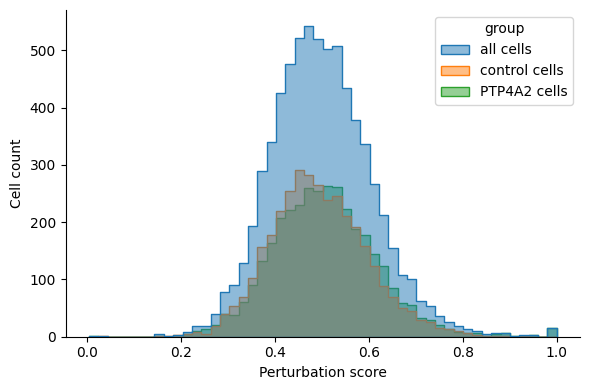

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plot_df = pd.concat(
    [
        subset_df_scaled.assign(group="all cells"),
        subset_df_scaled[subset_df_scaled["gene_symbol_0"] != GENE].assign(
            group="control cells"
        ),
        subset_df_scaled[subset_df_scaled["gene_symbol_0"] == GENE].assign(
            group=f"{GENE} cells"
        ),
    ]
)

plt.figure(figsize=(6, 4))
sns.histplot(
    data=plot_df,
    x="perturbation_score",
    hue="group",
    bins=50,
    element="step",
    fill=True,
    stat="count",
    common_norm=False,
    alpha=0.5,
)
plt.xlabel("Perturbation score")
plt.ylabel("Cell count")
sns.despine()
plt.tight_layout()
plt.show()

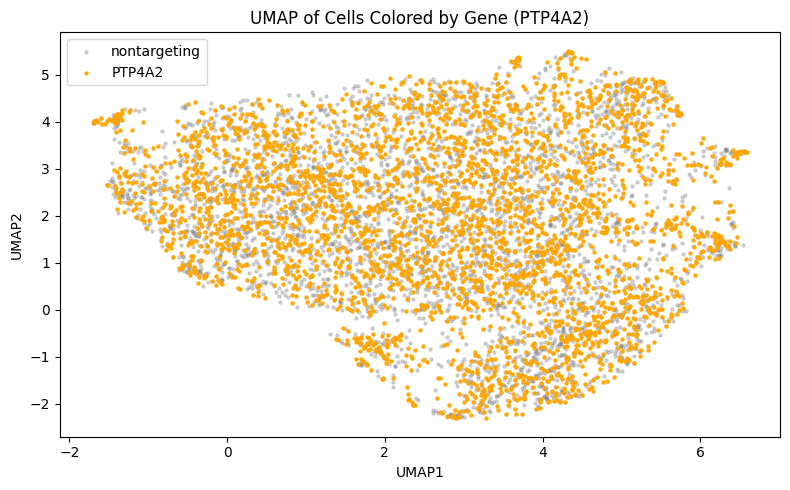

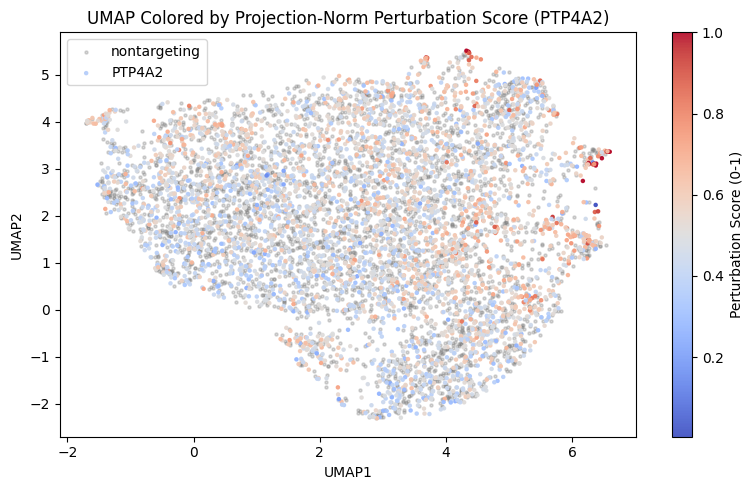

In [ ]:
# Prepare data
X = subset_df_scaled[diff_exp_features]
control_X = subset_df_scaled[
    subset_df_scaled["gene_symbol_0"].str.startswith("nontargeting")
][diff_exp_features]
is_gene = subset_df_scaled["gene_symbol_0"] == GENE

# UMAP
embedding = umap.UMAP(n_jobs=-1).fit_transform(X)

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(
    embedding[~is_gene, 0],
    embedding[~is_gene, 1],
    color="gray",
    s=5,
    alpha=0.3,
    label="nontargeting",
)
plt.scatter(
    embedding[is_gene, 0],
    embedding[is_gene, 1],
    color="orange",
    s=5,
    alpha=0.9,
    label=GENE,
)
plt.legend()
plt.title(f"UMAP of Cells Colored by Gene ({GENE})")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(
    embedding[~is_gene, 0],
    embedding[~is_gene, 1],
    c="gray",
    s=5,
    alpha=0.3,
    label="nontargeting",
)
plt.scatter(
    embedding[is_gene, 0],
    embedding[is_gene, 1],
    c=subset_df_scaled[is_gene]["perturbation_score"],
    cmap="coolwarm",
    s=5,
    alpha=0.9,
    label=GENE,
)
plt.legend()
plt.title(f"UMAP Colored by Projection-Norm Perturbation Score ({GENE})")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.colorbar(label="Perturbation Score (0-1)")
plt.tight_layout()
plt.show()